In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import nu_e_collisions as ve
import numba as nb
import time
import sympy as sym

In [2]:
def f(p,Tcm,c): #occupation fraction for the neutrinos we've been using
    return 1/(np.e**(c*p/Tcm)+1)

a = 0.2
T = 5.0
e_array = np.linspace(0,20,int(201))
boxsize = e_array[1]-e_array[0]
p_array = e_array / a
f_array = f(p_array,1/a,0.9*T * a)

In [3]:
%%time
net1 = ve.driver(p_array,T,f_array,boxsize*(1/a))

CPU times: user 6min 33s, sys: 4.44 s, total: 6min 38s
Wall time: 6min 42s


In [4]:
%%time
net2 = ve.driver_old(p_array,T,f_array,boxsize*(1/a))

CPU times: user 2min 33s, sys: 2.06 s, total: 2min 35s
Wall time: 2min 35s


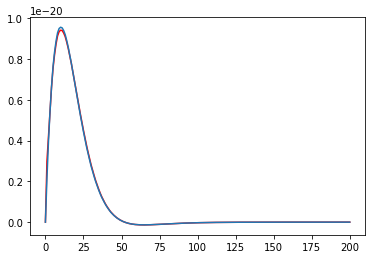

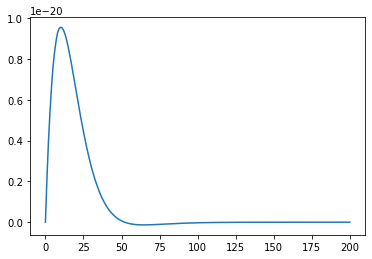

<ipython-input-5-3d93fa4ae673>:10: RuntimeWarning: invalid value encountered in true_divide
  plt.plot((net1-net2)/(net1+net2))


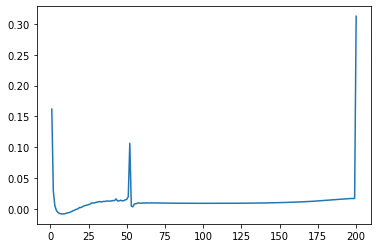

In [5]:
plt.figure()
plt.plot(net1, color='r')
plt.plot(net2)
plt.show()

plt.figure()
plt.plot(net2)
plt.show()

plt.plot((net1-net2)/(net1+net2))

In [6]:
x, y, p1, E2, E3, q3, q2, GF, stw, me = sym.symbols('x,y,p1,E2,E3,q3,q2,GF,stw,me')

M_1prime = 2**5 * GF**2 * (2 * stw + 1)**2 * ( x**2 - 2 * stw / (2 * stw + 1) *me**2*x )

M_1_1 = sym.integrate( M_1prime.subs(x, ((p1+E2)**2-me**2-y**2)/2), (y, p1+E2-E3-q3, p1+E2-E3+q3) )
M_11 = sym.lambdify((p1,E2,E3,q3),M_1_1.subs([(GF,1.166e-11),(stw,(np.sin(.4910015))**2)]))
M11 = nb.jit(M_11,nopython=True)

print(x)

x


In [7]:
a, b, c, d = sym.symbols('a,b,c,d')

z = a + b + 5
Z = sym.lambdify((a,b),z)
ZZ = nb.jit(Z,nopython=True)

print(Z(4,6))

print(ZZ(6,4))

15
15


## README file for ``nu_e_collisions.py`` 


This code models neutrino-electron/positron collisions in the early universe. It is run in ``basic_code.py`` (see https://github.com/hannahrasmussen/BasicCode). To make a ``nu_e_coll`` package, execute the following steps:

1. Navigate to the directory that your BasicCode folder is in. Make a folder there called ``nu_e_coll``, then make a folder within ``nu_e_coll`` that is also named ``nu_e_coll``.
2. Download ``nu_e_collisions.py`` from my GitHub page at https://github.com/hannahrasmussen/nu_e_coll (you've probably already done that if you're reading this) and put it in the folder within the folder.
3. In the folder (not the folder within the folder), put a ``setup.py`` folder with the following code:
        from setuptools import setup
        setup(name='nu_e_coll',
          version='0.1',
          description='Neutrino-electron/positron collision code',
          url='https://github.com/hannahrasmussen/nu_e_coll',
          author='Hannah Rasmussen',
          author_email='hannahrasmussen17@gmail.com',
          license='MIT',
          packages=['nu_e_coll'],
          zip_safe=False)
          
4. Now, go to the terminal and checkout your new folder (not the folder within a folder) using the ‘cd’ command. 
5. Once you’re there, type and enter ‘pip install -e .’ (including the period). That ‘-e’ extension means that updates you make to the code are automatically also installed, which is obviously what we want.
6. Now, to see if it worked, open a separate jupyter notebook kernel and try and do ‘from nu_e_coll import nu_e_collisions’. If there are no errors, you can delete that line and should be good to run the code as is.

## Imports 

* installs ``sympy``, a python library that 
* installs ``numpy``, a python package that allows for quick and easy computing using multi-dimensional arrays
* installs ``numba`` a python package designed to interface with ``numpy`` and make the code run significantly faster (at least one order of magnitude)
* from ``Interpolate`` imports ``interp``, a package that...

The ultimate goal of this code is to compute the sum-squared amplitude for neutrinos scattering off electrons $ \langle | \mathcal{M} | ^2 \rangle $. I will do my best to show a breakdown of $ \langle | \mathcal{M} | ^2 \rangle $ here:

$$ \begin{aligned} \langle | \mathcal{M} | ^2 \rangle &= \underset{E_3}{\int} \underset{E_2}{\int} \underset{p_1}{\int} M_1'(P_1 \cdot Q_2) + M_2'(P_1 \cdot Q_3) \\ &= \underset{E_3}{\int} \underset{E_2}{\int} \underset{p_1}{\int} 2^5 G_F^2 (2 \sin^2 \theta_w + 1)^2 \left( (P_1 \cdot Q_2)^2 - \frac{2 \sin^2 \theta_w}{2 \sin^2 \theta_w + 1} m_e^2(P_1 \cdot Q_2) \right) + 2^7 G_F^2 \sin^4 \theta_w \left( (P_1 \cdot Q_3)^2 + \frac{2 \sin^2 \theta_w + 1}{2 \sin^2 \theta_w} m_e^2 (P_1 \cdot Q_3) \right) \end{aligned} $$

It seems that the way $M_1'$ and $M_2'$ are integrated over depend on the momentum of the incoming neutrino, $p_1$. (but I thought the goal was simply to get $ \langle | \mathcal{M} | ^2 \rangle $ which is a sum of $M_1'$ and $M_2'$? ugh I guess $ \langle | \mathcal{M} | ^2 \rangle $ is probably just for a given $p_1$ or something and then we have to integrate over all possible incoming and outgoing electron energies (which then determine outgoing neutrino momenta), yeesh). Yea so all $R_1$ integrals are really integrating over $M_1'$ with respect to $y$, which is just a dummy variable for $(P_1 \cdot Q_2)$ (which is..????), and THEN we integrate over $E_3$ and $E_2$, which should return the resulting changes in neutrino distribution, i.e., $p_4$. Similarly, all  $R_2$ integrals are really integrating over $M_2'$ with respect to $y$, which is just a dummy variable for $(P_1 \cdot Q_3)$ (which is..????), and THEN we integrate over $E_2$ and $E_3$. 

The following applies for the first integral, $R_1$:

When $p_1 < m_e/2$, $R_1 = R_1^{(1)}$:
$$ R_1^{(1)} = \frac{1}{2^4 (2\pi)^3 p_1^2}\left[\int_{m_e}^{E_{\rm cut}^{(3)}} dE_2 \left[\int_{m_e}^{E_2}dE_3 F M_1^{(1)}\, + \int_{E_2}^{E_{\rm trans}^{(2)}}dE_3 F M_1^{(2)}\, + \int_{E_{\rm trans}^{(2)}}^{E_{\rm lim}^{(1)}}dE_3 F M_1^{(3)}\, \right]\, \\ + \int_{E_{\rm cut}^{(3)}}^{E_{\rm cut}^{(1)}} dE_2 \left[\int_{m_e}^{E_{\rm trans}^{(2)}}dE_3 F M_1^{(1)}\, + \int_{E_{\rm trans}^{(2)}}^{E_2}dE_3 F M_1^{(4)}\, + \int_{E_2}^{E_{\rm lim}^{(1)}}dE_3 F M_1^{(3)}\, \right] \\ + \int_{E_{\rm cut}^{(1)}}^{\infty} dE_2 \left[\int_{E_{\rm lim}^{(2)}}^{E_2}dE_3 F M_1^{(4)}\, + \int_{E_2}^{E_{\rm lim}^{(1)}}dE_3 F M_1^{(3)}\, \right]\, \right]$$

When $p_1 > m_e/2$, $R_1 = R_1^{(2)}$:
$$ R_1^{(2)} = \frac{1}{2^4 (2\pi)^3 p_1^2}\left[\int_{m_e}^{E_{\rm cut}^{(3)}} dE_2 \left[\int_{m_e}^{E_2}dE_3 F M_1^{(1)}\, + \int_{E_2}^{E_{\rm trans}^{(2)}}dE_3 F M_1^{(2)}\, + \int_{E_{\rm trans}^{(2)}}^{E_{\rm lim}^{(1)}}dE_3 F M_1^{(3)}\, \right]\, \\ + \int_{E_{\rm cut}^{(3)}}^{\infty} dE_2 \left[\int_{m_e}^{E_{\rm trans}^{(2}}dE_3 F M_1^{(1)}\,  + \int_{E_{\rm trans}^{(2)}}^{E_2}dE_3 F M_1^{(4)}\, + \int_{E_2}^{E_{\rm lim}^{(1)}}dE_3 F M_1^{(3)}\, \right]\,\right]$$

Where $F$ is the neutrino distribution (?) as sent by ``BasicCode``:
$$ F = F(p_1,E_2,E_3, p_4 = p_1 + E_2 - E_3) $$

I'm not really sure where a lot of these limits come from?
$$ E_{\rm cut}^{(1)} = m_e + \frac{2p_1^2}{m_e - 2p_1} $$
$$ E_{\rm cut}^{(3)} = \sqrt{p_1^2 + m_e^2} $$
$$ E_{\rm trans}^{(2)} = E_{\rm lim}^{(2)} = \frac{1}{2} \left( 2p_1 + E_2 - q_2 + \frac{m_e^2}{2p_1 + E_2 - q_2} \right) $$
$$ E_{\rm lim}^{(1)} = \frac{1}{2} \left( 2p_1 + E_2 + q_2 + \frac{m_e^2}{2p_1 + E_2 + q_2} \right) $$

$$ M_1^{(1)} (p_1, E_2, E_3, q_3) = \int_{p_1+E_2-E_3-q_3}^{p_1+E_2-E_3+q_3} dy\, M_1' ( \xi = \frac{1}{2} \left[ (p_1 + E_2)^2 - m_e^2 - y^2 \right] )$$
$$ M_1^{(2)} (p_1, q_2) = \int_{p_1-q_2}^{p_1+q_2} dy\, M_1' ( \xi = \frac{1}{2} \left[ (p_1 + E_2)^2 - m_e^2 - y^2 \right] )$$
$$ M_1^{(3)} (p_1, q_2) = \int_{E_3+q_3-p_1-E_2}^{p_1+q_2} dy\, M_1' ( \xi = \frac{1}{2} \left[ (p_1 + E_2)^2 - m_e^2 - y^2 \right] )$$
$$ M_1^{(4)} (p_1, q_2) = \int_{q_2-p_1}^{p_1+E_2-E_3+q_3} dy\, M_1' ( \xi = \frac{1}{2} \left[ (p_1 + E_2)^2 - m_e^2 - y^2 \right] )$$

The following applies for the second integral, $R_2$:

When $p_1 < m_e(\sqrt{5}-1)/4$, $R_2 = R_2^{(1)}$:
$$ R_2^{(1)} = \frac{1}{2^4 (2\pi)^3 p_1^2}\left[\int_{m_e}^{E_{\rm cut}^{(3)}} dE_3 \left[\int_{m_e}^{E_3}dE_2 F M_2^{(1)}\, + \int_{E_3}^{E_{\rm trans}^{(2)}}dE_2 F M_2^{(2)}\, + \int_{E_{\rm trans}^{(2)}}^{E_{\rm lim}^{(1)}}dE_2 F M_2^{(3)}\, \right]\, \\ + \int_{E_{\rm cut}^{(3)}}^{E_{\rm cut}^{(2)}} dE_3 \left[\int_{m_e}^{E_{\rm trans}^{(2)}}dE_2 F M_2^{(1)}\, + \int_{E_{\rm trans}^{(2)}}^{E_3}dE_2 F M_2^{(4)}\, + \int_{E_3}^{E_{\rm lim}^{(1)}}dE_2 F M_2^{(3)}\, \right] \\ + \int_{E_{\rm cut}^{(2)}}^{E_{\rm cut}^{(1)}} dE_3 \left[\int_{E_{\rm lim}^{(2)}}^{E_3}dE_2 F M_2^{(4)}\,  + \int_{E_3}^{E_{\rm lim}^{(1)}}dE_2 F M_2^{(3)}\, \right] \\ + \int_{E_{\rm cut}^{(1)}}^{\infty} dE_3 \left[\int_{E_{\rm lim}^{(2)}}^{E_3}dE_2 F M_2^{(4)}\, + \int_{E_3}^{\infty}dE_2 F M_2^{(3)}\, \right]\, \right]$$

When $m_e(\sqrt{5}-1)/4 < p_1 < m_e/2\sqrt{2} $, $R_2 = R_2^{(2)}$:
$$ R_2^{(2)} = \frac{1}{2^4 (2\pi)^3 p_1^2}\left[\int_{m_e}^{E_{\rm cut}^{(3)}} dE_3 \left[\int_{m_e}^{E_3}dE_2 F M_2^{(1)}\, + \int_{E_3}^{E_{\rm trans}^{(2)}}dE_2 F M_2^{(2)}\, + \int_{E_{\rm trans}^{(2)}}^{E_{\rm lim}^{(1)}}dE_2 F M_2^{(3)}\, \right]\, \\ + \int_{E_{\rm cut}^{(3)}}^{E_{\rm cut}^{(1)}} dE_3 \left[\int_{m_e}^{E_{\rm trans}^{(2)}}dE_2 F M_2^{(1)}\, + \int_{E_{\rm trans}^{(2)}}^{E_3}dE_2 F M_2^{(4)}\,  + \int_{E_3}^{E_{\rm lim}^{(1)}}dE_2 F M_2^{(3)}\, \right] \\ + \int_{E_{\rm cut}^{(1)}}^{E_{\rm cut}^{(2)}} dE_3 \left[\int_{m_e}^{E_{\rm trans}^{(2)}}dE_2 F M_2^{(1)}\, + \int_{E_{\rm trans}^{(2)}}^{E_3}dE_2 F M_2^{(4)}\, + \int_{E_3}^{\infty}dE_2 F M_2^{(3)}\, \right] \\ + \int_{E_{\rm cut}^{(2)}}^{\infty} dE_3 \left[\int_{E_{\rm lim}^{(2)}}^{E_3}dE_2 F M_2^{(4)}\,  + \int_{E_3}^{\infty}dE_2 F M_2^{(3)}\, \right]\, \right]$$

When $m_e/2\sqrt{2} < p_1 < m_e/2 $, $R_2 = R_2^{(3)}$:
$$ R_2^{(3)} = \frac{1}{2^4 (2\pi)^3 p_1^2}\left[\int_{m_e}^{E_{\rm cut}^{(1)}} dE_3 \left[\int_{m_e}^{E_3}dE_2 F M_2^{(1)}\, + \int_{E_3}^{E_{\rm trans}^{(2)}}dE_2 F M_2^{(2)}\, + \int_{E_{\rm trans}^{(2)}}^{E_{\rm lim}^{(1)}}dE_2 F M_2^{(3)}\, \right]\, \\ + \int_{E_{\rm cut}^{(1)}}^{E_{\rm cut}^{(3)}} dE_3 \left[\int_{m_e}^{E_3}dE_2 F M_2^{(1)}\,  + \int_{E_3}^{E_{\rm trans}^{(2)}}dE_2 F M_2^{(2)}\, + \int_{E_{\rm trans}^{(2)}}^{\infty}dE_2 F M_2^{(3)}\, \right] \\ + \int_{E_{\rm cut}^{(3)}}^{E_{\rm cut}^{(2)}} dE_3 \left[\int_{m_e}^{E_{\rm trans}^{(2)}}dE_2 F M_2^{(1)}\, + \int_{E_{\rm trans}^{(2)}}^{E_3}dE_2 F M_2^{(4)}\,  + \int_{E_3}^{\infty}dE_2 F M_2^{(3)}\, \right] \\ + \int_{E_{\rm cut}^{(2)}}^{\infty} dE_3 \left[\int_{E_{\rm lim}^{(2)}}^{E_3}dE_2 F M_2^{(4)}\,  + \int_{E_3}^{\infty}dE_2 F M_2^{(3)}\, \right]\, \right]$$

When $p_1 > m_e/2 $, $R_2 = R_2^{(4)}$:
$$ R_2^{(4)} = \frac{1}{2^4 (2\pi)^3 p_1^2}\left[\int_{m_e}^{E_{\rm cut}^{(1)}} dE_3 \left[\int_{m_e}^{E_3}dE_2 F M_2^{(1)}\, + \int_{E_3}^{\infty}dE_2 F M_2^{(2)} \right] \\ + \int_{E_{\rm cut}^{(1)}}^{E_{\rm cut}^{(3)}} dE_3 \left[\int_{m_e}^{E_3}dE_2 F M_2^{(1)}\,  + \int_{E_3}^{E_{\rm trans}^{(2)}}dE_2 F M_2^{(2)}\, + \int_{E_{\rm trans}^{(2)}}^{\infty}dE_2 F M_2^{(3)}\, \right] \\ + \int_{E_{\rm cut}^{(3)}}^{E_{\rm cut}^{(2)}} dE_3 \left[\int_{m_e}^{E_{\rm trans}^{(2)}}dE_2 F M_2^{(1)}\, + \int_{E_{\rm trans}^{(2)}}^{E_3} dE_2 F M_2^{(4)}\, + \int_{E_3}^{\infty}dE_2 F M_2^{(3)}\, \right] \\ + \int_{E_{\rm cut}^{(2)}}^{\infty} dE_3 \left[\int_{E_{\rm lim}^{(2)}}^{E_3}dE_2 F M_2^{(4)}\,  + \int_{E_3}^{\infty}dE_2 F M_2^{(3)}\, \right]\, \right]$$

Where $F$ is the neutrino distribution (?) as sent by ``BasicCode``:
$$ F = F(p_1,E_2,E_3, p_4 = p_1 + E_2 - E_3) $$

I'm not really sure where a lot of these limits come from?
$$ E_{\rm cut}^{(1)} = p_1 + \frac{m_e^2}{4p_1} $$
$$ E_{\rm cut}^{(2)} = p_1 + m_e\frac{p_1 + m_e}{2p_1 + m_e} $$
$$ E_{\rm cut}^{(3)} = \sqrt{p_1^2 + m_e^2} $$
$$ E_{\rm trans}^{(2)} = E_{\rm lim}^{(2)} = \frac{1}{2} \left( E_3 + q_3 - 2p_1 + \frac{m_e^2}{E_3 + q_3 - 2p_1} \right) $$
$$ E_{\rm lim}^{(1)} = \frac{1}{2} \left( E_3 - q_3 - 2p_1 + \frac{m_e^2}{E_3 - q_3 - 2p_1} \right) $$

$$ M_2^{(1)} (p_1, E_2, E_3, q_2) = \int_{p_1-E_3+E_2-q_2}^{p_1-E_3+E_2+q_2} dy\, M_2' ( \xi = \frac{1}{2} \left[ y^2 + m_e^2 - (p_1 - E_3)^2\right] )$$
$$ M_2^{(2)} (p_1, q_3) = \int_{p_1-q_3}^{p_1+q_3} dy\, M_2' ( \xi = \frac{1}{2} \left[ y^2 + m_e^2 - (p_1 - E_3)^2\right] )$$
$$ M_2^{(3)} (p_1, E_2, q_2, E_3, q_3) = \int_{E_3-p_1-E_2+q_2}^{p_1+q_3} dy\, M_2' ( \xi = \frac{1}{2} \left[ y^2 + m_e^2 - (p_1 - E_3)^2\right] )$$
$$ M_2^{(4)} (p_1, E_2, q_2, E_3, q_3) = \int_{q_3-p_1}^{p_1-E_3+E_2+q_2} dy\, M_2' ( \xi = \frac{1}{2} \left[ y^2 + m_e^2 - (p_1 - E_3)^2\right] )$$

## Constants

* ``Weinberg`` = .4910015, the Weinberg angle...
* Gauss-Laguerre quadrature: A mathematical tool to evaluate any integral from $[0,\infty)$ using Laguerre polynomials. You send $n$ to the function and it returns the $n$ roots of the $n^{\rm th}$ Laguerre polynomial. These $n$ roots are ``x_values``. Each root has a corresponding weight in ``w_values``. By evaluating $\sum_{i=1}^n w_i * e^{-x_i}f(x_i)$, an approximation for $\int_0^{\infty} f(x) dx$ is returned.
* ``x_values``: The $n$ roots of the $n^{\rm th}$ Laguerre polynomial
* ``w_values``: The weights that correspond to ``x_values``
* Gauss-Legendre quadrature: A mathematical tool to evaluate any integral from $[-1,1]$ using Legendre polynomials. You send $n$ to the function and it returns the $n$ roots of the $n^{\rm th}$ Legendre polynomial. These n roots are ``x_valuese``. Each root has a corresponding weight in ``w_valuese``. By evaluating $\sum_{i=1}^n w_i f(x_i)$, an approximation for $\int_{-1}^1 f(x) dx$ is returned. Note that this can be molded to calculate any definite integral, $\int_a^b f(x) dx$.
* ``x_valuese``: The $n$ roots of the $n^{\rm th}$ Legendre polynomial
* ``w_valuese``: The weights that correspond to ``x_valuese``
* ``me``: The mass of an electron, $m_e =0.511$ MeV
* ``inf``: An obscure float used as placeholder for an infinite upper limit, never actually used in calculations but used in decision trees, $\text{inf} = 6457.2$

## Sympy symbols and functions

This code uses the sympy package to make functions without all the 'def' and 'return' formalities, but I'm not really sure what the benefit of this because it is a bit difficult for me to read, it's probably faster? *sigh* I need to go read up on sympy now...

* ``x``: symbol that I think kind of just becomes a placeholder in a lot of these integrations...  should really probably be 'xi'
* ``y``: I think this is just a dummy variable of integration in all these M sympy functions...
* ``p1``: The momentum of the neutrino coming into the collision
* ``E2``: The energy of the electron coming into the collision
* ``E3``: The energy of the electron leaving the collision
* ``q3``: The momentum of the electron leaving the collision
* ``q2``: The momentum of the electron entering the collision
* ``GF``: symbol for the Fermi constant, $G_F = 1.166 \times 10 ^{-11} \text{ MeV}^{-2}$
* ``stw``: symbol for $\sin^2(\theta_w)$
* ``M_1prime``: the expression that a lot of the other functions integrate over:
$$\displaystyle M_1' (\xi) = 2^5 G_F^2 (2 \sin^2 \theta_w + 1)^2 \left( \xi^2 - \frac{2 \sin^2 \theta_w}{2 \sin^2 \theta_w + 1} m_e^2\xi \right)$$
* ``M_2prime``: the expression that a lot of the other functions integrate over:
$$\displaystyle M_2' (\xi) = 2^7 G_F^2 \sin^4 \theta_w \left( \xi^2 + \frac{2 \sin^2 \theta_w + 1}{2 \sin^2 \theta_w} m_e^2 \xi \right)$$
* ``M_1_1``: A component of several of the integrands calculated throughout this code...
$$\displaystyle  M_1^{(1)} (p_1, E_2, E_3, q_3) = \int_{p_1+E_2-E_3-q_3}^{p_1+E_2-E_3+q_3} dy\, M_1' ( \xi = \frac{1}{2} \left[ (p_1 + E_2)^2 - m_e^2 - y^2 \right] )$$
* ``M_11``: The lambdified version of ``M_1_1``
* ``M11``: The no-python version of ``M_11``
* ``M_1_2``: A component of several of the integrands calculated throughout this code...
$$\displaystyle  M_1^{(2)} (p_1, q_2) = \int_{p_1-q_2}^{p_1+q_2} dy\, M_1' ( \xi = \frac{1}{2} \left[ (p_1 + E_2)^2 - m_e^2 - y^2 \right] )$$
* ``M_12``: The lambdified version of ``M_1_2``
* ``M12``: The no-python version of ``M_12``
* ``M_1_3``: A component of several of the integrands calculated throughout this code...
$$\displaystyle  M_1^{(3)} (p_1, q_2) = \int_{E_3+q_3-p_1-E_2}^{p_1+q_2} dy\, M_1' ( \xi = \frac{1}{2} \left[ (p_1 + E_2)^2 - m_e^2 - y^2 \right] )$$
* ``M_13``: The lambdified version of ``M_1_3``
* ``M13``: The no-python version of ``M_13``
* ``M_1_4``: A component of several of the integrands calculated throughout this code...
$$\displaystyle  M_1^{(4)} (p_1, q_2) = \int_{q_2-p_1}^{p_1+E_2-E_3+q_3} dy\, M_1' ( \xi = \frac{1}{2} \left[ (p_1 + E_2)^2 - m_e^2 - y^2 \right] )$$
* ``M_14``: The lambdified version of ``M_1_4``
* ``M14``: The no-python version of ``M_14``
* ``M_2_1``: A component of several of the integrands calculated throughout this code...
$$\displaystyle  M_2^{(1)} (p_1, E_2, E_3, q_2) = \int_{p_1-E_3+E_2-q_2}^{p_1-E_3+E_2+q_2} dy\, M_2' ( \xi = \frac{1}{2} \left[ y^2 + m_e^2 - (p_1 - E_3)^2\right] )$$
* ``M_21``: The lambdified version of ``M_2_1``
* ``M21``: The no-python version of ``M_21``
* ``M_2_2``: A component of several of the integrands calculated throughout this code...
$$\displaystyle  M_2^{(2)} (p_1, q_3) = \int_{p_1-q_3}^{p_1+q_3} dy\, M_2' ( \xi = \frac{1}{2} \left[ y^2 + m_e^2 - (p_1 - E_3)^2\right] )$$
* ``M_22``: The lambdified version of ``M_2_2``
* ``M22``: The no-python version of ``M_22``
* ``M_2_3``: A component of several of the integrands calculated throughout this code...
$$\displaystyle  M_2^{(3)} (p_1, E_2, q_2, E_3, q_3) = \int_{E_3-p_1-E_2+q_2}^{p_1+q_3} dy\, M_2' ( \xi = \frac{1}{2} \left[ y^2 + m_e^2 - (p_1 - E_3)^2\right] )$$
* ``M_23``: The lambdified version of ``M_2_3``
* ``M23``: The no-python version of ``M_23``
* ``M_2_4``: A component of several of the integrands calculated throughout this code...
$$\displaystyle  M_2^{(4)} (p_1, E_2, q_2, E_3, q_3) = \int_{q_3-p_1}^{p_1-E_3+E_2+q_2} dy\, M_2' ( \xi = \frac{1}{2} \left[ y^2 + m_e^2 - (p_1 - E_3)^2\right] )$$
* ``M_24``: The lambdified version of ``M_2_4``
* ``M24``: The no-python version of ``M_24``

## Ancillary functions

### ``trapezoid`` 
* **Imports**
    * ``array``:
    * ``dx``:
* **Outputs**:
    * ``total``:

### ``fe`` 
* **Imports**
    * ``E``:
    * ``T``:
* **Outputs**:
    * 
    
### ``make_q_array`` 
* **Imports**
    * ``Energy_array``:
* **Outputs**:
    * ``q_array``:

## Interpolation Functions
    
### ``lin_int`` 
* **Imports**
    * ``X``:
    * ``x``:
    * ``y``:
* **Outputs**:
    * ``Y``:
   
### ``interp`` 
* **Imports**
    * ``p4``:
    * ``f``:
    * ``bx``:
* **Outputs**:
    * ``Y``:   

### ``interp_log`` 
* **Imports**
    * ``p4``:
    * ``f``:
    * ``bx``:
* **Outputs**:
    * ``Y``:

### ``linear_extrap`` 
* **Imports**
    * ``X``:
    * ``x``:
    * ``y``:
* **Outputs**:
    * ``Y``:

### ``log_linear_extrap`` 
* **Imports**
    * ``X``:
    * ``x``:
    * ``y``:
* **Outputs**:
    * ``Y``:
    
### ``f_first_last`` 
* **Imports**
    * ``f``:
    * ``p4_array``:
    * ``boxsize``:
* **Outputs**:
    * ``f_first``:
    * ``f_last``:
    * ``j``:
    * ``k``:

## Returning limits and M functions, lots of decision trees

### ``Blim`` 
* **Imports**
    * ``p1``: The neutrino momentum at the current box in ``driver``, serves as the incoming neutrino momentum $p_1$ in integrations.
    * ``E``:
    * ``q``:
    * ``T``: The plasma temperature at a given time step.
    * ``f``: The occupation fraction of active neutrinos, will be non-thermal in our models. $f$ is a function of epsilon, but since we send boxsize as an argument, an array of epsilon can be calculated later as necessary.
    * ``bx``: The boxsize in ``p_arr``.
    * ``sub``: The subsscript of the term being calculated, either 1 or 2.
    * ``sup``: The superscript of the term being calculated, either 1, 2, 3, or 4.
    * ``n``: The number of the term being calculated, either 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, or 11.
* **Outputs**:
    * ``UL``:
    * ``LL``:
    
### ``Alim`` 
* **Imports**
    * ``p1``: The neutrino momentum at the current box in ``driver``, serves as the incoming neutrino momentum $p_1$ in integrations.
    * ``sub``: The subsscript of the term being calculated, either 1 or 2.
    * ``sup``: The superscript of the term being calculated, either 1, 2, 3, or 4.
    * ``n``: The number of the term being calculated, either 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, or 11.
* **Outputs**:
    * ``UL``:
    * ``LL``:
    
### ``M`` 
* **Imports**
    * ``p1``: The neutrino momentum at the current box in ``driver``, serves as the incoming neutrino momentum $p_1$ in integrations.
    * ``E_arr``:
    * ``q_arr``:
    * ``E_val``:
    * ``q_val``:
    * ``sub``: The subsscript of the term being calculated, either 1 or 2.
    * ``sup``: The superscript of the term being calculated, either 1, 2, 3, or 4.
    * ``n``: The number of the term being calculated, either 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, or 11.
* **Outputs**:
    * ``M_arr``:

## A and B functions

### ``B`` 
* **Imports**
    * ``p1``: The neutrino momentum at the current box in ``driver``, serves as the incoming neutrino momentum $p_1$ in integrations.
    * ``E_val``: The energy of the electron at the current step in the for loop in ``A``. This can be either $E_2$ (for $R_1$) or $E_3$ (for $R_2$). At this stage it does not matter if it is $E_2$ or $E_3$, it simply matters that it is not the energy we will be integrating over, which will be ``E_arr``.
    * ``T``: The plasma temperature at a given time step.
    * ``f``: The occupation fraction of active neutrinos, will be non-thermal in our models. $f$ is a function of epsilon, but since we send boxsize as an argument, an array of epsilon can be calculated later as necessary.
    * ``bx``: The boxsize in ``p_arr``.
    * ``sub``: The subsscript of the term being calculated, either 1 or 2. Ultimately sent to ``Alim``, ``Blim``, and ``M`` to calculate the proper limits for the A integral, B integral, and M function.
    * ``sup``: The superscript of the term being calculated, either 1, 2, 3, or 4. Ultimately sent to ``Alim``, ``Blim``, and ``M`` to calculate the proper limits for the A integral, B integral, and M function.
    * ``n``: The number of the term being calculated, either 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, or 11. Ultimately sent to ``Alim``, ``Blim``, and ``M`` to calculate the proper limits for the A integral, the propser limits for the B integral, and the correct M function, respectively.
* **Calculations**
    * ``q_val``: The momentum of the electron that corresponds to ``E_val``, $q_{\rm val} = \sqrt{E_{\rm val}^2-m_e^2}$
    * ``UL``: The upper limit of the B integral as calculated by the function ``Blim``
    * ``LL``: The lower limit of the B integral as calculated by the function ``Blim``
    * ``p4_arr``: The array of momenta of outgoing neutrinos from collisions from this particular term.
    * ``Fp_arr``: The 
    * ``Fm_arr``: 
    * ``p1_box``: 
    * ``E_arr``:
    * ``q_arr``:
    * ``M_arr``:
* **Outputs**:
    * ``igrlp``:
    * ``igrlm``:
    
### ``A`` 
The "A" integrals are those on the "outside" in the R functions, i.e., the integrals over $E_2$ for $R_1$ and the integrals over $E_3$ for $R_2$. First, ``Alim`` is called to determine the limits of the current A term, and if the upper limit (``UL``) is infinite, we integrate using Gauss-Laguerre quadrature. If the upper limit is not infinite, we integrate using Gauss-Legendre quadrature. In both cases, we integrate over ``E_arr``, an array of energies, by using a for loop to calculate the integrand of the given ``A`` integral by calling ``B`` at the given index of ``E_arr`` (it does not matter at this stage if ``E_arr`` refers to $E_2$, the energy of the incoming electron, or $E_3$, the energy of the outgoing electron, so we do not differentiate between the two cases here).
* **Imports**
    * ``p1``: The neutrino momentum at the current box in ``driver``, serves as the incoming neutrino momentum $p_1$ in integrations.
    * ``T``: The plasma temperature at a given time step.
    * ``f``: The occupation fraction of active neutrinos, will be non-thermal in our models. $f$ is a function of epsilon, but since we send boxsize as an argument, an array of epsilon can be calculated later as necessary.
    * ``bx``: The boxsize in ``p_arr``.
    * ``sub``: The subsscript of the term being calculated, either 1 or 2. Ultimately sent to ``Alim``, ``Blim``, and ``M`` to calculate the proper limits for the A integral, B integral, and M function.
    * ``sup``: The superscript of the term being calculated, either 1, 2, 3, or 4. Ultimately sent to ``Alim``, ``Blim``, and ``M`` to calculate the proper limits for the A integral, B integral, and M function.
    * ``n``: The number of the term being calculated, either 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, or 11. Ultimately sent to ``Alim``, ``Blim``, and ``M`` to calculate the proper limits for the A integral, the propser limits for the B integral, and the correct M function, respectively.
* **Calculations**
    * ``UL``: The upper limit of the A integral as calculated by the function ``Alim``
    * ``LL``: The lower limit of the A integral as calculated by the function ``Alim``
* **Outputs**:
    * ``igrlp``: Short for "integral plus", this is the calculated integral of all outgoing neutrinos from the collisions being added to the distribution at new momenta. This is returned as a two-index array with ``igrlm`` for ease of calculation in the ``R`` functions.
    * ``igrlm``: Short for "integral minus", this is the calculated integral of all incoming neutrinos that went into collisions being taken away from the distribution. This is returned as a two-index array with ``igrlp`` for ease of calculation in the ``R`` functions.

## R and driver functions

### ``R11R21`` 
When $p_1 < \frac{m_e\sqrt{5}-1}{4}$, $R_1 = R_1^{(1)}$ and $R_2=R_2^{(1)}$. This function calculates both of these values by calling the function ``A`` for each of the 8 terms in $R_1^{(1)}$ and each of the 10 terms in $R_2^{(1)}$ and adding the results (and multiplying by the coefficient of $\frac{1}{2^4 (2\pi)^3 p_1^2}$) to get the total integral. However, we have really computed two integrals here, one of those neutrinos added to boxes, and one of those taken away (``igrlp`` and ``igrlm`` from ``A``). It is their \textit{difference} that we want to return to driver to get the net change in neutrino distribution. 

Due to computational error, there will be some small differences between these two integrals that we do not want to treat as "true" differences. It is for this reason that we added the if statement that simply returns 0 if the relative difference between the integrals is less than $10^{-14}$.
* **Imports**
    * ``p1``: The neutrino momentum at the current box in ``driver``, serves as the incoming neutrino momentum $p_1$ in integrations.
    * ``T``: The plasma temperature at a given time step.
    * ``f``: The occupation fraction of active neutrinos, will be non-thermal in our models. $f$ is a function of epsilon, but since we send boxsize as an argument, an array of epsilon can be calculated later as necessary.
    * ``bx``: The boxsize in ``p_arr``.
* **Outputs**:
    * ``net``: The difference between the "positive" integral and the "negative" integral; i.e. the net change in neutrino distribution from this round of collision integrals.
    
### ``R11R22`` 
When $\frac{m_e\sqrt{5}-1}{4}< p_1 < \frac{m_e}{2\sqrt{2}}$, $R_1 = R_1^{(1)}$ and $R_2=R_2^{(2)}$. This function calculates both of these values by calling the function ``A`` for each of the 8 terms in $R_1^{(1)}$ and each of the 11 terms in $R_2^{(2)}$ and adding the results (and multiplying by the coefficient of $\frac{1}{2^4 (2\pi)^3 p_1^2}$) to get the total integral. However, we have really computed two integrals here, one of those neutrinos added to boxes, and one of those taken away (``igrlp`` and ``igrlm`` from ``A``). It is their \textit{difference} that we want to return to driver to get the net change in neutrino distribution. 

Due to computational error, there will be some small differences between these two integrals that we do not want to treat as "true" differences. It is for this reason that we added the if statement that simply returns 0 if the relative difference between the integrals is less than $10^{-14}$.
* **Imports**
    * ``p1``: The neutrino momentum at the current box in ``driver``, serves as the incoming neutrino momentum $p_1$ in integrations
    * ``T``: the plasma temperature at a given time step
    * ``f``: the occupation fraction of active neutrinos, will be non-thermal in our models. $f$ is a function of epsilon, but since we send boxsize as an argument, an array of epsilon can be calculated later as necessary
    * ``bx``: the boxsize in ``p_arr``
* **Outputs**:
    * ``net``: The difference between the "positive" integral and the "negative" integral; i.e. the net change in neutrino distribution from this round of collision integrals.
    
### ``R11R23`` 
When $\frac{m_e}{2\sqrt{2}} < p_1 < \frac{m_e}{2}$, $R_1 = R_1^{(1)}$ and $R_2=R_2^{(3)}$. This function calculates both of these values by calling the function ``A`` for each of the 8 terms in $R_1^{(1)}$ and each of the 11 terms in $R_2^{(3)}$ and adding the results (and multiplying by the coefficient of $\frac{1}{2^4 (2\pi)^3 p_1^2}$) to get the total integral. However, we have really computed two integrals here, one of those neutrinos added to boxes, and one of those taken away (``igrlp`` and ``igrlm`` from ``A``). It is their \textit{difference} that we want to return to driver to get the net change in neutrino distribution. 

Due to computational error, there will be some small differences between these two integrals that we do not want to treat as "true" differences. It is for this reason that we added the if statement that simply returns 0 if the relative difference between the integrals is less than $10^{-14}$.
* **Imports**
    * ``p1``: The neutrino momentum at the current box in ``driver``, serves as the incoming neutrino momentum $p_1$ in integrations
    * ``T``: the plasma temperature at a given time step
    * ``f``: the occupation fraction of active neutrinos, will be non-thermal in our models. $f$ is a function of epsilon, but since we send boxsize as an argument, an array of epsilon can be calculated later as necessary
    * ``bx``: the boxsize in ``p_arr``
* **Outputs**:
    * ``net``: The difference between the "positive" integral and the "negative" integral; i.e. the net change in neutrino distribution from this round of collision integrals.
    
### ``R12R24`` 
When $<\frac{m_e}{2} < p_1 $, $R_1 = R_1^{(2)}$ and $R_2=R_2^{(4)}$. This function calculates both of these values by calling the function ``A`` for each of the 6 terms in $R_1^{(2)}$ and each of the 10 terms in $R_2^{(4)}$ and adding the results (and multiplying by the coefficient of $\frac{1}{2^4 (2\pi)^3 p_1^2}$) to get the total integral. However, we have really computed two integrals here, one of those neutrinos added to boxes, and one of those taken away (``igrlp`` and ``igrlm`` from ``A``). It is their \textit{difference} that we want to return to driver to get the net change in neutrino distribution. 

Due to computational error, there will be some small differences between these two integrals that we do not want to treat as "true" differences. It is for this reason that we added the if statement that simply returns 0 if the relative difference between the integrals is less than $10^{-14}$.
* **Imports**
    * ``p1``: The neutrino momentum at the current box in ``driver``, serves as the incoming neutrino momentum $p_1$ in integrations
    * ``T``: the plasma temperature at a given time step
    * ``f``: the occupation fraction of active neutrinos, will be non-thermal in our models. $f$ is a function of epsilon, but since we send boxsize as an argument, an array of epsilon can be calculated later as necessary
    * ``bx``: the boxsize in ``p_arr``
* **Outputs**:
    * ``net``: The difference between the "positive" integral and the "negative" integral; i.e. the net change in neutrino distribution from this round of collision integrals.
    
### ``driver`` 
This function is called from ``Basic_Code.py`` and has the primary purpose of running a for loop through ``p_arr`` to call the correct $R$ function for the given momentum. For ``p_arr[i]`` $<\frac{m_e\sqrt{5}-1}{4}$, the function ``R11R21`` is called. For $\frac{m_e\sqrt{5}-1}{4}<$ ``p_arr[i]`` $<\frac{m_e}{2\sqrt{2}}$, the function ``R11R22`` is called. For $\frac{m_e}{2\sqrt{2}}<$ ``p_arr[i]`` $<\frac{m_e}{2}$, the function ``R11R23`` is called. For $\frac{m_e}{2}<$ ``p_arr[i]``, the function ``R12R24`` is called. 
* **Imports**
    * ``p_arr``: array of active neutrinos' momenta at a given time step 
    * ``T``: the plasma temperature at a given time step
    * ``f``: the occupation fraction of active neutrinos, will be non-thermal in our models. $f$ is a function of epsilon, but since we send boxsize as an argument, an array of epsilon can be calculated later as necessary
    * ``bx``: the boxsize in ``p_arr``, assumes that this boxsize doesn't vary but I feel like that is not good...
* **Outputs**:
    * ``output_arr``: An array of the differences in occupation fraction, positive values signifies neutrinos are being added at a given momenta and negative values signifies neutrinos are being taken away from that momenta (I'm not really sure if it's percent differences or what? how does this output get integrated into BasicCode?)